In [11]:
import glob
import os

from astropy.time import Time
import astropy.units as u
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd 
import scipy.stats as st
from sklearn.neighbors import KernelDensity

import huxt as H
import huxt_analysis as HA
import SIR_HUXt as sir

mpl.rc("axes", labelsize=16)
mpl.rc("ytick", labelsize=16)
mpl.rc("xtick", labelsize=16)
mpl.rc("legend", fontsize=16)

In [12]:
dirs = sir.get_project_dirs()

data_dir = os.path.join(dirs['sir_analysis'], "uniform_wind_resample_v", "SIR_HUXt_*.hdf5")
files = glob.glob(data_dir)

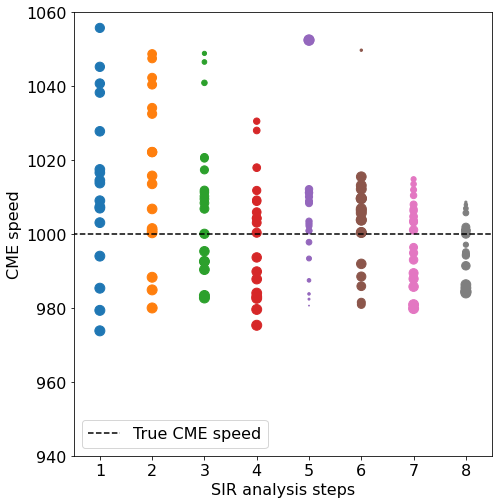

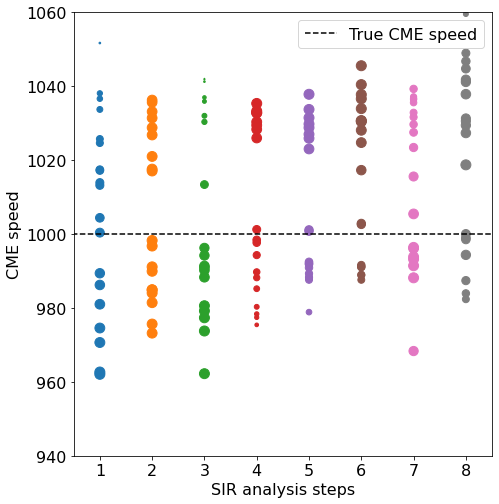

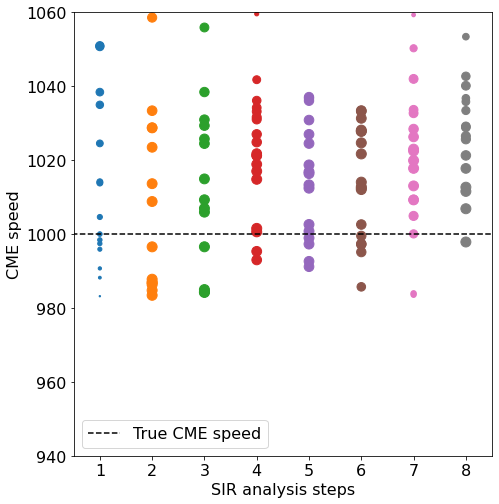

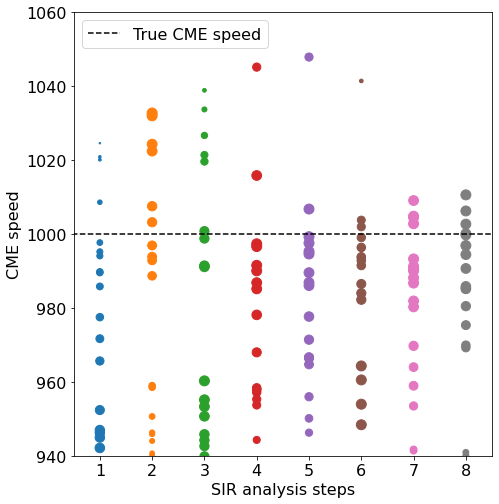

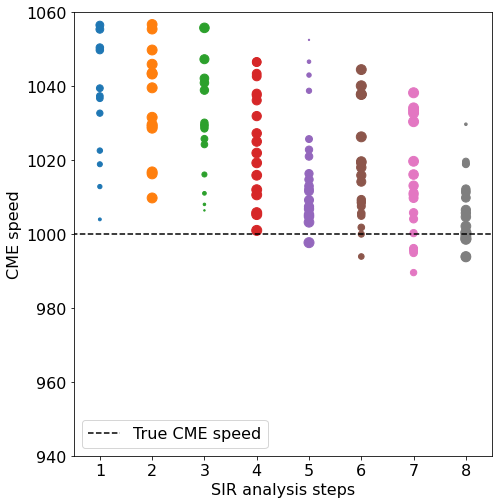

In [13]:
for j in range(5):
    out_file = h5py.File(files[j], 'r')

    fig, ax = plt.subplots(figsize=(7, 7))

    v_truth = out_file['cme_params'][:][4]

    for i in range(8):

        key = "analysis_{:02d}".format(i)
        
        v = out_file[key]['speed'][:]
        weights = out_file[key]['weight'][:]
        sz = 100*(weights - np.min(weights)) / (np.max(weights) - np.min(weights))

        y = np.ones(v.shape) + i
        ax.scatter(y, v, s=sz, marker='o')
        
    ax.hlines(v_truth, 0, 9, linestyles=['--'], colors=['k'], label='True CME speed')
    ax.set_xlim(0.5, 8.5)
    ax.set_ylim(940,1060)
    ax.set_xlabel('SIR analysis steps')
    ax.set_ylabel('CME speed')
    ax.legend()
    
    
    fig.subplots_adjust(left=0.15, bottom=0.1, right=0.98, top=0.98, wspace=0.1)
    #fig.savefig('parameter_vs_step_{:02d}.png'.format(j))

    out_file.close()



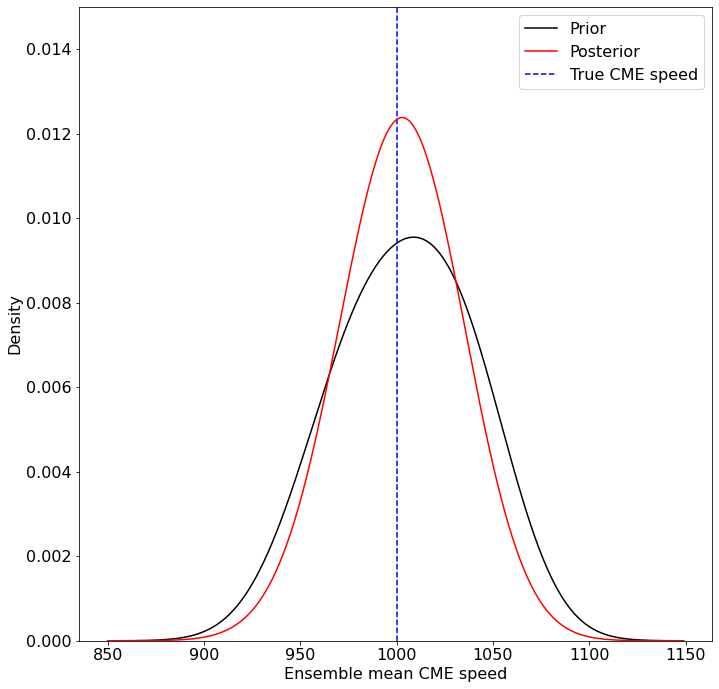

In [14]:
key_0 = "analysis_00"
v_avg_0 = [] 

key_7 = "analysis_07"
v_avg_7 = [] 

for f in files:

    out_file = h5py.File(f, 'r')

    cme_truth_params = out_file['cme_params'][:]
    v_truth = cme_truth_params[4]

    v = out_file[key_0]['speed'][:]
    v_avg_0.append(np.mean(v))

    v = out_file[key_7]['speed'][:]
    v_avg_7.append(np.mean(v))

    out_file.close()

fig, ax = plt.subplots(figsize=(10, 10))

v_avg_0 = np.array(v_avg_0)
v_avg_7 = np.array(v_avg_7)

for v, col, label in zip([v_avg_0, v_avg_7], ['k', 'r'], ['Prior', 'Posterior']):

    kde = KernelDensity(kernel='gaussian', bandwidth=25).fit(v.reshape(-1,1))
    v_grid = np.arange(850, 1150, 1)
    log_pdf = kde.score_samples(v_grid.reshape(-1,1))
    pdf = np.exp(log_pdf)

    ax.plot(v_grid, pdf, color=col, label=label)

ax.vlines(v_truth,0, 0.02, colors=['b'], linestyles=['--'], label='True CME speed')

ax.set_xlabel('Ensemble mean CME speed')
ax.set_ylabel('Density')
ax.set_ylim(0,0.015)
ax.legend()

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.98, wspace=0.1)
#fig.savefig('ensemble_mean_speed_kde.png')


analysis_00 18.68791792026761 19.861672489684498 19.999866561749172
analysis_07 14.189975901513034 19.39485973137243 19.992079403791404


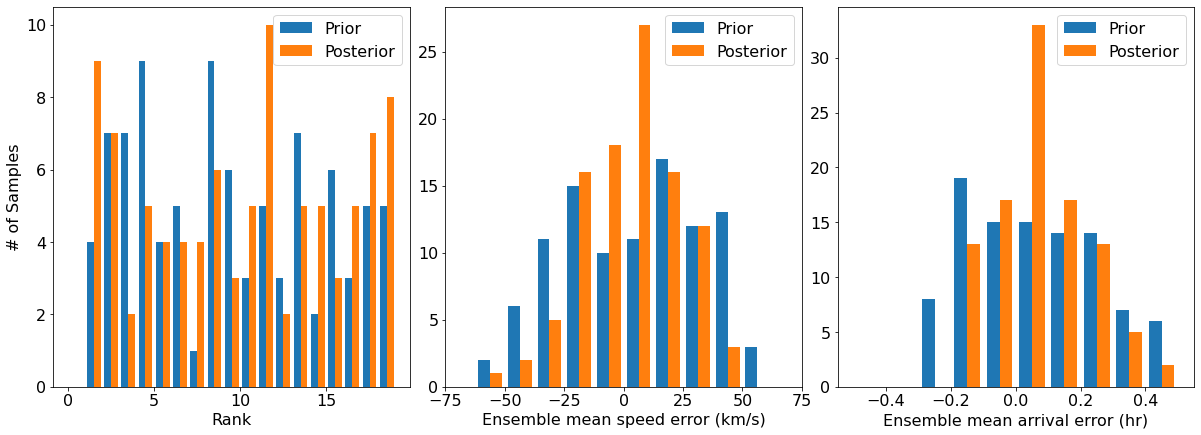

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

rank_all = []
v_err_all = []
t_err_all = []

for k in [0,7]:

    key = "analysis_{:02d}".format(k)

    rank_hist_data = []
    v_err = []
    t_err = []
    ess_all = []
    for f in files:

        out_file = h5py.File(f, 'r')

        v = out_file[key]['speed'][:]        
        cme_truth_params = out_file['cme_params'][:]
        v_truth = cme_truth_params[4]
        v_all = np.append(v,v_truth)
        v_ranks = st.rankdata(v_all)
        rank_hist_data.append(v_ranks[-1])
        v_err.append(np.mean(v) - v_truth)

        t_arr_truth = out_file['t_arrive'][()]
        t_arr = out_file[key]['arrival'][:]

        t_err.append(24*(np.mean(t_arr) - t_arr_truth))

        w = out_file[key]['weight'][:]   
        ess = 1 / np.sum(w**2)
        ess_all.append(ess)

        out_file.close()

    print(key, np.min(ess_all), np.mean(ess_all), np.max(ess_all))

    rank_all.append(rank_hist_data)
    v_err_all.append(v_err)
    t_err_all.append(t_err)


ax[0].hist(rank_all, bins=np.arange(0,len(v)), label=['Prior', 'Posterior'])
ax[1].hist(v_err_all, bins=np.arange(-100,100,12.5), label=['Prior', 'Posterior'])
ax[2].hist(t_err_all, bins=np.arange(-0.6, 0.6, 0.1), label=['Prior', 'Posterior'])

ax[0].set_xlabel('Rank')
ax[1].set_xlabel('Ensemble mean speed error (km/s)')
ax[2].set_xlabel('Ensemble mean arrival error (hr)')

ax[0].set_ylabel('# of Samples')

for a in ax:
    a.legend()
    
ax[1].set_xlim(-75, 75)
ax[2].set_xlim(-0.55, 0.55)
    
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=0.98, wspace=0.1)
#fig.savefig('rank_and_mean_error_hists.png')